In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary

from imgaug import augmenters as iaa

In [2]:
trn_fmnist = datasets.FashionMNIST('./data', train=True, download=True)
val_fmnist = datasets.FashionMNIST('./data', train=False, download=True)

trn_fmnist.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [105]:
class FmnistDataset(Dataset):
    def __init__(self, x, y, aug=None):
        super().__init__()

        self.x = x.unsqueeze(1).float().to(device) / 255
        self.y = y
        self.aug = aug

    def __len__(self):
        return len(self.x)

    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]
    
    def collate_fn(self, batch):
        x, y = zip(*batch)
        x = np.stack(x).transpose((0, 2, 3, 1)) * 255
        
        if self.aug:
            x = self.aug.augment_images(x)

        return torch.tensor(x.transpose(0, 3, 1, 2)) / 255, torch.tensor(y)

threshold = 2000
aug = iaa.Sequential([
    iaa.SaltAndPepper(0.15),
    iaa.Affine(translate_percent=(-0.2, 0.2), rotate=(-30, 30)),
])
trn_dataset = FmnistDataset(trn_fmnist.data[:threshold], trn_fmnist.targets[:threshold], aug)
trn_dataloader = DataLoader(trn_dataset, 512, collate_fn=trn_dataset.collate_fn)
val_dataset =FmnistDataset(val_fmnist.data[:threshold], val_fmnist.targets[:threshold])

In [106]:
def measure_accuracy(_y: torch.Tensor, y: torch.Tensor):
    return ((_y >= 0.5) == y).sum() / y.shape[0]

In [206]:
model = nn.Sequential(
    nn.Conv2d(1, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 32, 3),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 16, 3),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),

    nn.Linear(16, 60),
    nn.BatchNorm1d(60),
    nn.Sigmoid(),

    nn.Linear(60, 30),
    nn.BatchNorm1d(30),
    nn.Tanh(),
    
    nn.Linear(30, 10),
)

opt = optim.Adam(model.parameters(), 0.01)
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    factor=0.4,
    threshold=0.01,
    min_lr=0.0001,
    threshold_mode='rel',
    patience=3,
)

In [209]:
epochs = 30

trn_losses = []
trn_accuracies = []

val_losses = []
val_accuracies = []

for epoch in range(epochs):
    avg_trn_loss = 0
    for x, y in trn_dataloader:
        model.train()

        _y = model(x)
        loss = criterion(_y, y)
        avg_trn_loss += loss.item()

        accuracy = measure_accuracy(_y, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        trn_losses.append(loss.item())
        trn_accuracies.append(accuracy.item())

        with torch.no_grad():
            model.eval()

            _y_val = model(val_dataset.x)

            val_losses.append(criterion(_y_val, val_dataset.y))
            val_accuracies.append((_y_val.argmax(dim=-1) == val_dataset.y).sum() / len(val_dataset))

    avg_trn_loss /= len(trn_dataloader)
    scheduler.step(avg_trn_loss)

    print(f"Epoch: {epoch}, Mean Trn Loss: {avg_trn_loss}, Val Accuracy: {val_accuracies[-1]}, LR: {opt.param_groups[0]['lr']}")

Epoch: 0, Mean Trn Loss: 0.8305380344390869, Val Accuracy: 0.5335000157356262, LR: 0.01
Epoch: 1, Mean Trn Loss: 0.8111325651407242, Val Accuracy: 0.6050000190734863, LR: 0.01
Epoch: 2, Mean Trn Loss: 0.823199525475502, Val Accuracy: 0.6794999837875366, LR: 0.01
Epoch: 3, Mean Trn Loss: 0.779657393693924, Val Accuracy: 0.6664999723434448, LR: 0.01
Epoch: 4, Mean Trn Loss: 0.7957218140363693, Val Accuracy: 0.6735000014305115, LR: 0.01
Epoch: 5, Mean Trn Loss: 0.8155284821987152, Val Accuracy: 0.6869999766349792, LR: 0.01
Epoch: 6, Mean Trn Loss: 0.7781140953302383, Val Accuracy: 0.6614999771118164, LR: 0.01
Epoch: 7, Mean Trn Loss: 0.7909003347158432, Val Accuracy: 0.6775000095367432, LR: 0.004
Epoch: 8, Mean Trn Loss: 0.7660578638315201, Val Accuracy: 0.6740000247955322, LR: 0.004
Epoch: 9, Mean Trn Loss: 0.7650709450244904, Val Accuracy: 0.6865000128746033, LR: 0.004
Epoch: 10, Mean Trn Loss: 0.7467253506183624, Val Accuracy: 0.6980000138282776, LR: 0.004
Epoch: 11, Mean Trn Loss: 0.7

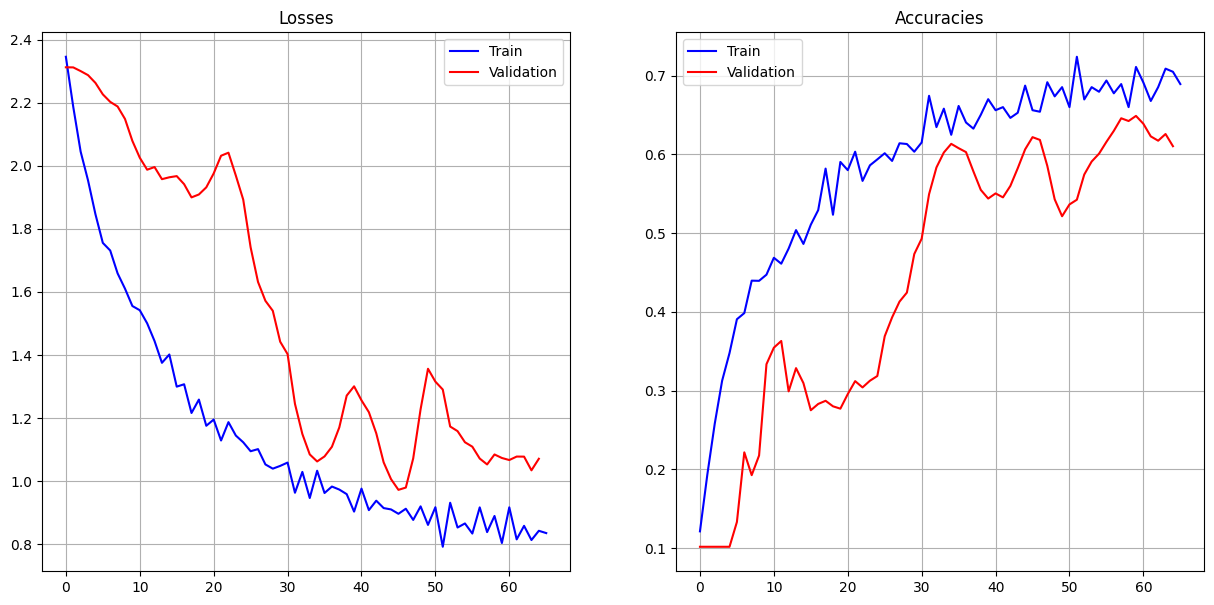

In [208]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].plot(range(len(trn_losses)), trn_losses, color='blue', label='Train')
axs[0].plot(range(len(val_losses)), val_losses, color='red', label='Validation')

axs[0].set_title("Losses")
axs[0].legend()
axs[0].grid()


axs[1].plot(range(len(trn_accuracies)), trn_accuracies, color='blue', label='Train')
axs[1].plot(range(len(val_accuracies)), val_accuracies, color='red', label='Validation')

axs[1].set_title("Accuracies")
axs[1].legend()
axs[1].grid()

In [ ]:
summary(model, trn_dataloader.dataset.x[0][None])

'Ankle boot'

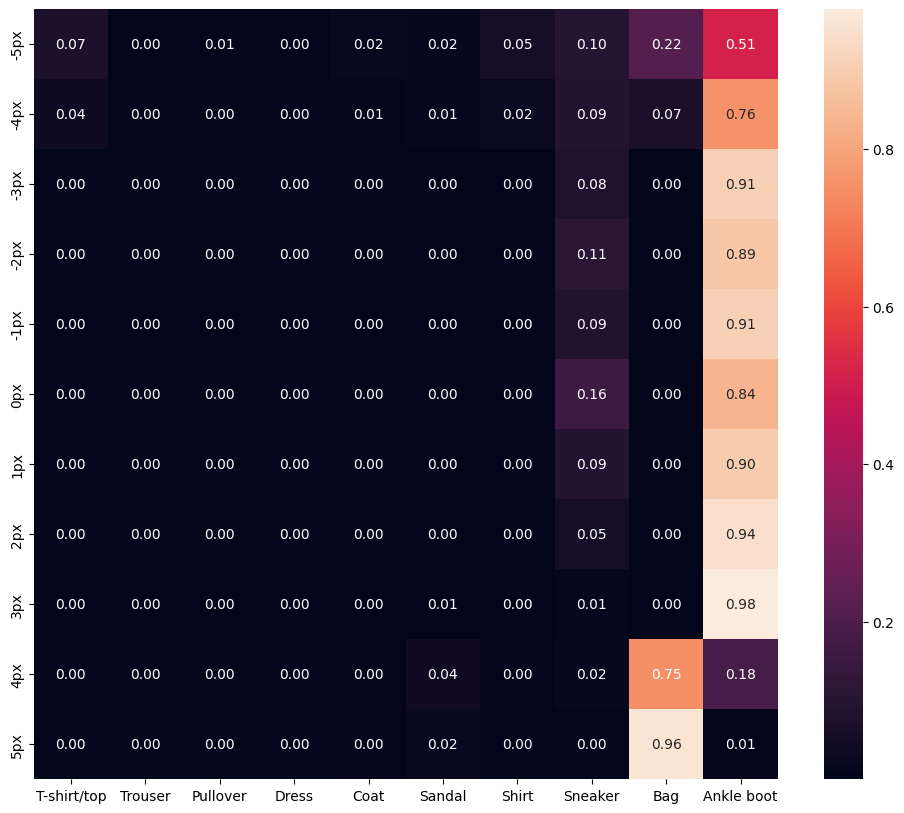

In [193]:
ix = 15
img_data, img_target = trn_dataloader.dataset[ix]

probs = [model(img_data.roll(px)[None]).softmax(dim=-1)[0].detach() for px in range(-5, 6)]

fig, ax = plt.subplots(1,1, figsize=(12, 10))
sns.heatmap(
    np.array(probs),
    annot=True,
    ax=ax,
    xticklabels=trn_fmnist.classes,
    yticklabels= [f'{i}px' for i in range(-5, 6)],
    fmt='.2f'
)

trn_fmnist.classes[img_target]

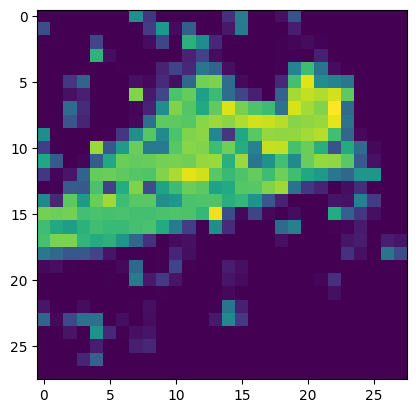

In [104]:
for x, y in trn_dataloader:
    plt.imshow(x[3].squeeze(0))

Text(0.5, 1.0, 'shear')

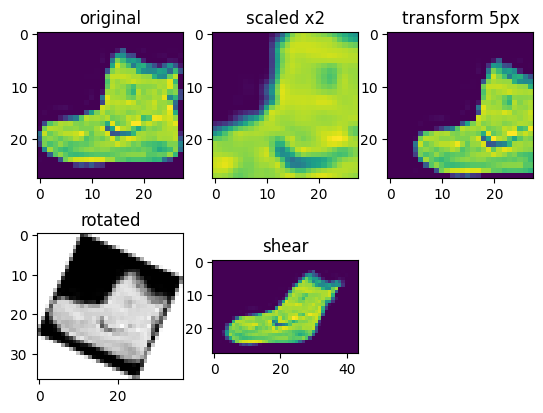

In [55]:
img_data = trn_dataloader.dataset.x[0].squeeze(0).numpy() * 255

scale_aug = iaa.Affine(scale=2)
transform_aug = iaa.Affine(translate_px={'x': 5, 'y': 2})
rotate_aug = iaa.Affine(rotate=(-45, 45), fit_output=True, cval=255, mode='constant')
shear_aug = iaa.Affine(shear=30, fit_output=True)

plt.subplot(231)
plt.imshow(img_data)
plt.title("original")

plt.subplot(232)
plt.imshow(scale_aug.augment_image(img_data))
plt.title("scaled x2")

plt.subplot(233)
plt.imshow(transform_aug.augment_image(img_data))
plt.title("transform 5px")

plt.subplot(234)
plt.imshow(rotate_aug.augment_image(img_data), cmap='gray')
plt.title("rotated")

plt.subplot(235)
plt.imshow(shear_aug.augment_image(img_data))
plt.title("shear")

In [ ]:
mult_aug = iaa.Multiply(2)
lin_constrast_aug = iaa.LinearContrast(0.8)
blur_aug = iaa.GaussianBlur(sigma=1)

plt.subplot(231)
plt.imshow(img_data, cmap='gray', vmin=0, vmax=255)
plt.title('original')

plt.subplot(232)
plt.imshow(mult_aug.augment_image(img_data), cmap='grey', vmin=0, vmax=255)
plt.title('multiply')

plt.subplot(233)
plt.imshow(lin_constrast_aug.augment_image(img_data), cmap='grey', vmin=0, vmax=255)
plt.title('linear contrast')

plt.subplot(234)
plt.imshow(blur_aug.augment_image(img_data), cmap='grey', vmin=0, vmax=255)

In [ ]:
dropout_aug = iaa.Dropout(0.2)
salt_and_pepper_aug = iaa.SaltAndPepper(0.3)

plt.subplot(131)
plt.imshow(img_data, cmap='gray', vmin=0, vmax=255)
plt.title('original')

plt.subplot(132)
plt.imshow(dropout_aug.augment_image(img_data), cmap='grey', vmin=0, vmax=255)
plt.title('dropout')

plt.subplot(133)
plt.imshow(salt_and_pepper_aug.augment_image(img_data), cmap='grey', vmin=0, vmax=255)
plt.title('salt and pepper')

In [62]:
seq_aug = iaa.Sequential([
    iaa.Affine(rotate=(-30, 30)),
    iaa.SaltAndPepper(0.2),
], random_order=True)

In [ ]:
plt.imshow(seq_aug.augment_image(img_data))

In [151]:
imgs_32 = trn_dataloader.dataset.x[:].squeeze(1)
imgs_32 = [img.numpy() for img in imgs_32]

def pltBatch(batch):
    fig, axs = plt.subplots(6, 6, figsize=(10, 10))
    axs = axs.flat

    for i, ax in enumerate(imgs_32):
        axs[i].imshow(imgs_32[i])
        axs[i].axis('off')

In [ ]:
aug = iaa.Sequential([
    iaa.Affine(translate_px=(-10, 10), rotate=(-30, 30)),
    iaa.SaltAndPepper(0.2),
    iaa.LinearContrast(0.8),
])

import time

start_loop = time.time()
augmented_imgs = [aug.augment_image(img) for img in imgs_32]
end_loop = time.time()

start_batch = time.time()
augmented_imgs = aug.augment_images(imgs_32)
end_batch = time.time()

f'Loop: {end_loop - start_loop}, Batch: {end_batch - start_batch}'